<a href="https://www.kaggle.com/code/fizcogar/intro-ia-transferencia-en-deteccion-de-objetos?scriptVersionId=115881506" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introducción a la Inteligencia Artificial
## Aprendizaje profundo
### Transferencia de aprendizaje en detección de objetos para control de calidad


# Caso de uso
Los cableados para automoción se montan a mano. En los tableros en los que los operarios montan los cables hay sistemas de control de calidad que miden la continuidad eléctica de los cables para detectar cables mal conectados.

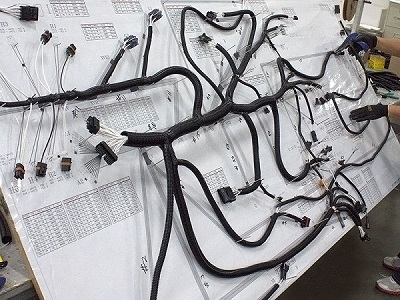

Las cajas de fusibles son un problema: un fusible equivocado, de un amperaje diferente al correcto, no puede ser detectado por continuidad eléctrica. 

Es un problema importante, porque un fusible es un mecanismo de seguridad. ¡Un fusible de 30 amperios colocado en el lugar de uno de 15 amperios no se va a fundir en caso de sobrecarga!

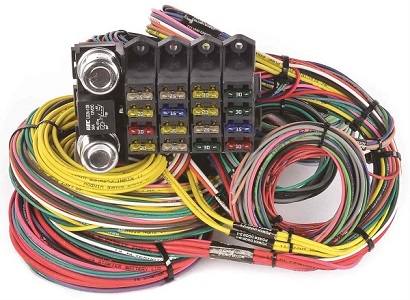

Para resolver el problema vamos a entrenar un modelo de aprendizaje profundo para **detección de objetos**. El modelo detectará cada posición y amperaje de los fusibles, de manera que, una vez integrado el modelo en el sistema de control de calidad, éste pueda compararlas con los valores correctos.

Este cuaderno es una adaptación del tutorial de GluonCV https://cv.gluon.ai/build/examples_detection/demo_ssd.html

# Librería: GluonCV

Vamos a usar [GluonCV](https://cv.gluon.ai/), la librería especializada en visión artificial de [Apache MXNet](https://mxnet.apache.org)

Primero, instalamos la librería:

In [1]:
pip install --upgrade gluoncv

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz

/opt/conda/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.11.0` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


# Dataset:

Es un conjunto de datos creado a medida: unas pocas imágenes de cajas de fusibles para automóviles.

Preparar un conjunto de entrenamiento siempre es costoso. En el caso de la detección de objetos hay que **localizar y etiquetar** cada objeto.

Hay herramientas, como [Label Studio](https://labelstud.io/), que ayudan a generar el conjunto de datos en el **formato adecuado** para el modelo.

En el siguiente vídeo puedes ver cómo se prepara el dataset con [Label Studio](https://labelstud.io/).
* Primero se elige la etiqueta, de las tres posibles ('10a', '15a' y '20a, para los fusibles de 10 amperios, 15 amperios y 20 amperios, respectivamente).
* Entonces se 'dibuja' el recuadro que localiza el fusible en la imagen de la caja

Y así para cada fusible.

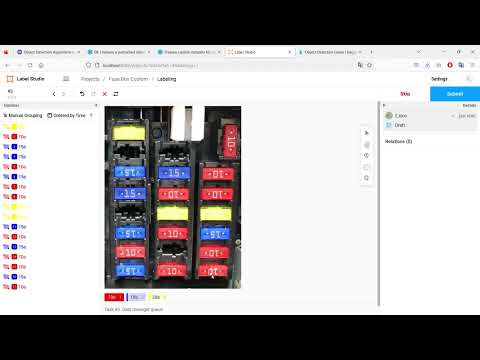

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('MDagBQx3Rf0')

## Dataset

Esta es la forma de cargar un dataset en GluonCV:

In [4]:
from gluoncv.data import VOCDetection
class VOCLike(VOCDetection):
    CLASSES = ['10a', '15a', '20a']
    def __init__(self, root, splits, transform=None, index_map=None, preload_label=True):
        super(VOCLike, self).__init__(root, splits, transform, index_map, preload_label)

dataset = VOCLike(root='/kaggle/input/fuse-box-custom', splits=((2018, 'train'),))

## Ejemplo del dataset

Aquí esta uno de los ejemplo del dataset: una caja de todos los fusibles localizados y corréctamente etiquetados:

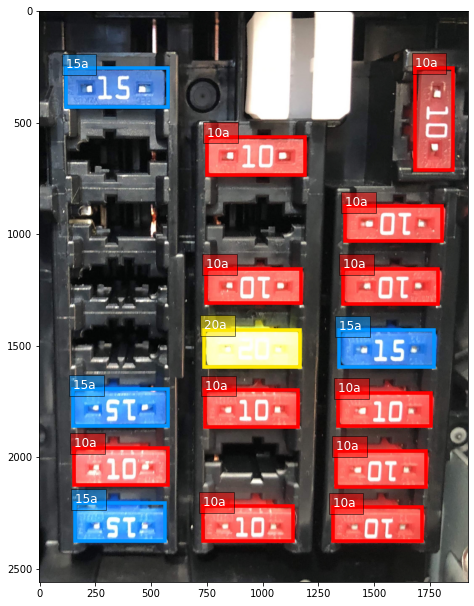

In [5]:
# Colores RGB para los recuadros
rojo = (1,0,0)
azul = (0,0.58,1)
amarillo = (1, 0.91, 0)
# Las tres etiquetas para los tres tipos de fusibles:
classes = ['10a','15a','20a'] 
image, label = dataset[0]
#print('label:', label)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes, colors={0: rojo, 1:azul, 2:amarillo})
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()


# Afinado (fine tuning)

## Modelo preentrenado basado en MobileNet

El modelo, implementado por la propia librería, es una arquitectura [Mobilenet](https://paperswithcode.com/method/mobilenetv1) entrenada para el algoritmo  de detección de objetos **'Single Shot MultiBox Detector' (SSD)**, otro algoritmo rápido de detección de objetos, entrenada en el 'dataset' público [Visual Object Classes (PASCAL VOC)](http://host.robots.ox.ac.uk/pascal/VOC/) 

[Mobilenet](https://paperswithcode.com/method/mobilenetv1) es un tipo de red neuronal convolucional diseñada para crear redes neuronales profundas ligeras, adecuadas para móviles y dispositivos de potencia limitada.

In [6]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained = True) 
net.reset_class(classes)
# now the output layers that used to map to VOC classes are now reset to distinguish new objects.

/opt/conda/lib/python3.7/site-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


50217KB [00:02, 20570.86KB/s]                           


## Cargador de datos (Data loader) para el modelo:

In [7]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 512, 16, 0)

# Esto fallaría si no encuentra GPU:
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
except:
    ctx = [mx.cpu()]

## Entrenamiento

El modelo tiene varios hyperparámetros, y se necesita **experimentación** para que el entrenamiento sea ágil. 

Después de unas pruebas un buen valor para el ratio de aprendizaje parece ser **lr=0.01**

In [8]:
ratio_aprendizaje = 0.01 # 0.001 originalmente
num_epocas = 250

net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate':ratio_aprendizaje, 'wd': 0.0005, 'momentum': 0.9})

mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

start = time.time()

# Bucle de entrenamiento. Cada 'vuelta' del bucle es una 'época':
for epoch in range(0, num_epocas):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 1 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()
        
end = time.time()

[09:02:13] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


[Epoch 3][Batch 0], Speed: 0.623 samples/sec, CrossEntropy=11.708, SmoothL1=4.569
[Epoch 7][Batch 0], Speed: 1.729 samples/sec, CrossEntropy=8.613, SmoothL1=2.534
[Epoch 11][Batch 0], Speed: 1.633 samples/sec, CrossEntropy=8.207, SmoothL1=1.886
[Epoch 15][Batch 0], Speed: 1.355 samples/sec, CrossEntropy=5.304, SmoothL1=2.450
[Epoch 19][Batch 0], Speed: 2.058 samples/sec, CrossEntropy=4.792, SmoothL1=0.845
[Epoch 23][Batch 0], Speed: 1.606 samples/sec, CrossEntropy=4.306, SmoothL1=1.754
[Epoch 27][Batch 0], Speed: 1.538 samples/sec, CrossEntropy=3.622, SmoothL1=1.397
[Epoch 31][Batch 0], Speed: 1.531 samples/sec, CrossEntropy=4.121, SmoothL1=1.398
[Epoch 35][Batch 0], Speed: 1.475 samples/sec, CrossEntropy=3.406, SmoothL1=1.214
[Epoch 39][Batch 0], Speed: 1.345 samples/sec, CrossEntropy=3.255, SmoothL1=1.093
[Epoch 43][Batch 0], Speed: 1.358 samples/sec, CrossEntropy=2.973, SmoothL1=1.167
[Epoch 47][Batch 0], Speed: 1.110 samples/sec, CrossEntropy=2.914, SmoothL1=2.385
[Epoch 51][Batch 

El tiempo dedicado al entrenamiento, en segundos, es:

In [9]:
print("Tiempo de entrenamiento (segundos):", end-start)

Tiempo de entrenamiento (segundos): 663.187087059021


Salvamos el modelo en disco:

In [10]:
net.save_parameters('ssd_512_mobilenet1.0_fuse-box.params')

# Inferencia

Este modelo debería **integrarse en el sistema de control de calidad** de los tableros de montaje del cableado.

Recuperamos el modelo y lo probamos con uno de los datos de validación:

In [11]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_fuse-box.params')
#net.load_parameters('ssd_512_mobilenet1.0_fuse-box.best.params') #El mejor resultado, 500 épocas, CrossEntropy=1.316

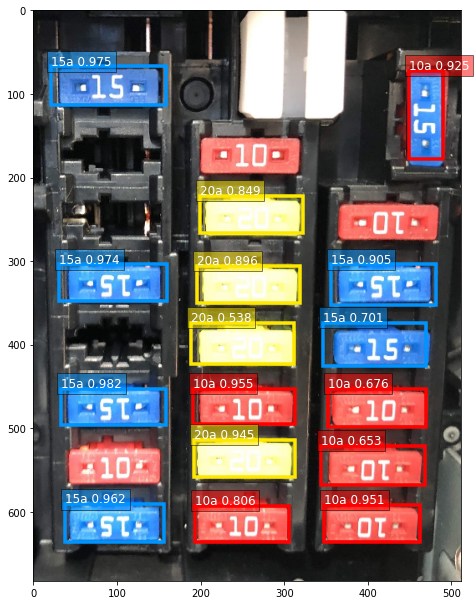

In [12]:
# Modelo
x, image = gcv.data.transforms.presets.ssd.load_test('/kaggle/input/fuse-box-custom/VOC2018/JPEGImages/b6ec47dc-000005.jpg', 512)
# Inferencia
cid, score, bbox = net(x)
# Representación gráfica
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes, colors={0: rojo, 1:azul, 2:amarillo})
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

El resultado es prometedor, pero no es perfecto. Puedes probar con más épocas de entrenamiento, pero dudo que sea posible encontrar un modelo suficientemente bueno como para que pudiese ser usado en producción **sin más datos de entrenamiento**. Este sería un ejemplo de un **modelo con falta de ajuste (underfitting)** por falta de datos de entrenamiento.

## Paso a producción

Si ampliamos el conjunto de datos de entrenamiento con más datos representativos podríamos llegar a tener un modelo digno de pasar a producción, **integrándolo** en el sistema de control de calidad de los tableros.

El resultado de la inferencia son tres listas (**cid, score y bbox**) en las que están los valores de las etiquetas, probabilidad y posición, respectivamente, de cada objeto detectado.

El sistema de control de calidad tendría que **comparar** estos valores con los valores correctos del modelo de caja de fusibles correspondientes
y **mostrar una imagen con LOS ERRORES** para que el operario pudiera corregirlos.

Veamos las etiquetas. 0 es '10a', 1 es '15a' y 2 es '20a'

In [13]:
cid


[[[ 1.]
  [ 1.]
  [ 1.]
  [ 1.]
  [ 0.]
  [ 0.]
  [ 2.]
  [ 0.]
  [ 1.]
  [ 2.]
  [ 2.]
  [ 0.]
  [ 1.]
  [ 0.]
  [ 0.]
  [ 2.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 1.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 1.]
  [ 1.]
  [ 0.]
  [ 1.]
  [ 1.]
  [ 2.]
  [ 1.]
  [ 1.]
  [ 0.]
  [ 2.]
  [ 1.]
  [ 1.]
  [ 0.]
  [ 0.]
  [ 2.]
  [ 2.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 2.]
  [ 1.]
  [ 2.]
  [ 0.]
  [ 2.]
  [ 1.]
  [ 1.]
  [ 1.]
  [ 0.]
  [ 1.]
  [ 0.]
  [ 1.]
  [ 0.]
  [ 1.]
  [ 0.]
  [ 0.]
  [ 2.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]]]
<NDArray 1x100x1 @cpu(0)>

¿Por qué hay tantas? Porque hay muchas más predicciones, pero sólo se aceptan aquellas con una **probabilidad > 0.5**

Las probabilidades:

In [14]:
score


[[[ 0.9822254 ]
  [ 0.97492766]
  [ 0.9744586 ]
  [ 0.9620834 ]
  [ 0.95461535]
  [ 0.9508768 ]
  [ 0.9452881 ]
  [ 0.9250499 ]
  [ 0.9054241 ]
  [ 0.89624935]
  [ 0.8493937 ]
  [ 0.8062427 ]
  [ 0.70067483]
  [ 0.67604756]
  [ 0.6526137 ]
  [ 0.5379364 ]
  [ 0.49792954]
  [ 0.49697977]
  [ 0.3581188 ]
  [ 0.35185343]
  [ 0.30599877]
  [ 0.24349736]
  [ 0.17873587]
  [ 0.17662075]
  [ 0.1617309 ]
  [ 0.15496357]
  [ 0.1427381 ]
  [ 0.12664473]
  [ 0.12533623]
  [ 0.09876116]
  [ 0.09755474]
  [ 0.0799272 ]
  [ 0.07411736]
  [ 0.07404737]
  [ 0.07334853]
  [ 0.07009891]
  [ 0.06772555]
  [ 0.05073869]
  [ 0.04568988]
  [ 0.04473411]
  [ 0.03879659]
  [ 0.03735036]
  [ 0.03432715]
  [ 0.03266728]
  [ 0.03072774]
  [ 0.03031471]
  [ 0.02901323]
  [ 0.02385139]
  [ 0.02332043]
  [ 0.02184931]
  [ 0.02042423]
  [ 0.02021702]
  [ 0.01934849]
  [ 0.01862441]
  [ 0.01837524]
  [ 0.01693024]
  [ 0.01691237]
  [ 0.01663841]
  [ 0.01603386]
  [ 0.01547826]
  [ 0.01454583]
  [ 0.01380706]
  [ 0.0

Y las posiciones de los objetos detectados. Cada fila son las coordenadas de dos esquinas que definen la posición de los fusibles detectados.

In [15]:
bbox


[[[ 33.749935 453.43225  158.86937  496.66406 ]
  [ 21.558258  67.931046 158.69925  113.16565 ]
  [ 31.757423 304.12506  160.57864  348.89075 ]
  [ 38.786144 591.4845   156.62082  636.5908  ]
  [191.50682  453.34674  313.8484   495.52203 ]
  [348.20273  592.9721   462.37314  636.50885 ]
  [192.13885  514.91     313.66635  558.99725 ]
  [449.97107   72.52605  490.69324  178.89499 ]
  [356.21698  304.72745  482.62347  352.38095 ]
  [196.80946  306.33636  319.5844   350.7763  ]
  [199.11166  222.49475  323.61063  266.97446 ]
  [193.3512   593.37244  306.9273   636.0344  ]
  [346.74786  374.66928  470.20496  426.64047 ]
  [352.81708  453.60822  470.6997   499.77222 ]
  [344.5056   521.8369   469.5511   568.7682  ]
  [188.06409  374.55945  312.3048   423.56427 ]
  [191.84784  143.49763  326.21613  195.25783 ]
  [360.15442  232.70879  487.87524  276.99854 ]
  [351.18756  375.72876  466.62006  422.5395  ]
  [ 29.575386 239.91512   86.72448  256.1182  ]
  [194.81259  143.95773  319.4739   192